In [326]:
import pandas as pd
import numpy as np
import re
import cv2 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import easyocr

plt.style.use('ggplot')


# easyocr

* final

In [327]:
reader = easyocr.Reader(['en','hi'], gpu = True)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


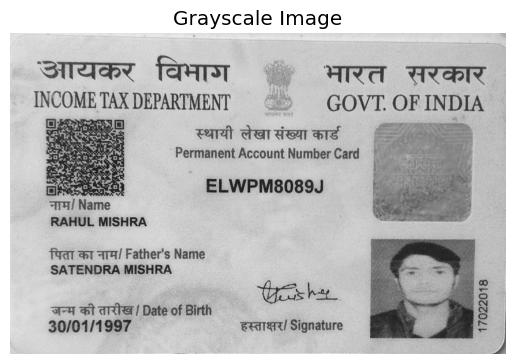

In [350]:
def preprocess(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # contrast the image 
    image = cv2.convertScaleAbs(image, -1, alpha=0.9,beta=1.5) 

    # Check the image dimensions
    (h, w) = image.shape[:2]

    # If the image is in landscape orientation
    if w > h:
        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Rotate the image to portrait orientation
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, 90, 1.0)
        image = cv2.warpAffine(image, M, (h, w), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    else:
        # Image is already in portrait orientation, grayscale of original image
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return gray


# Automatically rotate the image to portrait orientation if in landscape
gray_image = preprocess('sample data/pan1_sample.png')

# # Display the grayscale image
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()


In [356]:
results = reader.readtext(gray_image)
df=pd.DataFrame(results, columns=['bbox','text','conf'])
df['text']=df['text'].apply(lambda x : re.sub(".*(नाम|तारीख ).","",x))
pattern = re.compile(r'^[a-zA-Z0-9!@#$%^&*()_+-=|" "]+$')
df['type']=df['text'].apply(lambda x:pattern.match(x))
df['text']=df['text'].apply(lambda x :np.nan if bool(re.findall(r'(Digitally|sign|Physically|Valid|unless).*',x,flags=re.IGNORECASE)) else x) #removing sign cell
df['text']=df['text'].apply(lambda x: np.nan if str(x).isnumeric() else x) #removing issue date since causing error
df=df.dropna()
df.drop(columns=['type'],inplace=True)
# removing sign photo if detected logic
index_to_drop = df['conf'].idxmin()
df.drop(index_to_drop, inplace=True)
df=df.reset_index(drop=True)

In [357]:
df # this df will be use to create the bounding boxes

,bbox,text,conf
0,"[[49, 131], [535, 131], [535, 195], [49, 195]]",INCOME TAX DEPARTMENT,0.942949
1,"[[748, 141], [1132, 141], [1132, 196], [748, 1...",GOVT OF INDIA,0.729422
2,"[[389, 268], [837, 268], [837, 308], [389, 308]]",Permanent Account Number Card,0.549247
3,"[[462, 340], [752, 340], [752, 388], [462, 388]]",ELWPM8089J,0.716735
4,"[[93, 393], [245, 393], [245, 429], [93, 429]]",Name,0.566830
5,"[[94, 434], [328, 434], [328, 466], [94, 466]]",RAHUL MISHRA,0.759206
6,"[[87, 507], [471, 507], [471, 548], [87, 548]]",Fathers Name,0.448627
7,"[[93, 547], [389, 547], [389, 583], [93, 583]]",SATENDRA MISHRA,0.728721
8,"[[95, 637], [487, 637], [487, 679], [95, 679]]",Date of Birth,0.728475
9,"[[85, 675], [293, 675], [293, 719], [85, 719]]",30/01/1997,0.877613


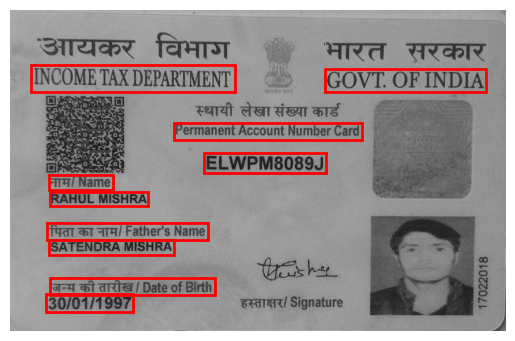

In [358]:
def plot_bounding_boxes(df, image_path):
    # Read the image
    # image = cv2.imread(image_path)
    
    # Plot the image
    fig, ax = plt.subplots()
    ax.imshow(cv2.cvtColor(gray_image, cv2.COLOR_BGR2RGB))

    # Add bounding boxes, text, and confidence scores
    for index, row in df.iterrows():
        # Get bounding box coordinates
        bbox = row['bbox']
        x1, y1 = bbox[0]
        x2, y2 = bbox[2]

        # Add bounding box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    # Show plot
    plt.axis('off')
    plt.show()

plot_bounding_boxes(df,gray_image)

---

In [359]:
def ocr_text(df):
    try:
        new_rows=[]
        for i,r in df.iterrows():
            new_rows.append(r.to_dict())
        # Create a new DataFrame with the added rows
        df_new = pd.DataFrame(new_rows)
        
        keys=list(df_new['text'].iloc[::2])
        values=list(df_new['text'].iloc[1::2])

        df_new=pd.DataFrame({"key":keys,
                    "value":values})
        
        return df_new
    except:
        print("Erorr")

In [360]:
ocr_text(df) # df_new will be used to check the facts

,key,value
0,INCOME TAX DEPARTMENT,GOVT OF INDIA
1,Permanent Account Number Card,ELWPM8089J
2,Name,RAHUL MISHRA
3,Fathers Name,SATENDRA MISHRA
4,Date of Birth,30/01/1997


In [361]:
import os

folder_path = "uploads"

# Get the current working directory
current_directory = os.getcwd()

# List all files and directories in the uploads folder
contents = os.listdir(folder_path)

# Iterate through each item in the folder
for item in contents:
    item_path = os.path.join(folder_path, item)
    # Check if the item is a file
    if os.path.isfile(item_path):
        # Extract the filename and full path
        file_name = os.path.basename(item_path)
        # Get the relative path
        relative_path = os.path.relpath(item_path, current_directory)
        # print("Image Name:", file_name)
        print(relative_path)


In [362]:
index_to_drop = df['conf'].idxmin()
df.drop(index_to_drop, inplace=True)

In [363]:
df

,bbox,text,conf
0,"[[49, 131], [535, 131], [535, 195], [49, 195]]",INCOME TAX DEPARTMENT,0.942949
1,"[[748, 141], [1132, 141], [1132, 196], [748, 1...",GOVT OF INDIA,0.729422
2,"[[389, 268], [837, 268], [837, 308], [389, 308]]",Permanent Account Number Card,0.549247
3,"[[462, 340], [752, 340], [752, 388], [462, 388]]",ELWPM8089J,0.716735
4,"[[93, 393], [245, 393], [245, 429], [93, 429]]",Name,0.566830
5,"[[94, 434], [328, 434], [328, 466], [94, 466]]",RAHUL MISHRA,0.759206
7,"[[93, 547], [389, 547], [389, 583], [93, 583]]",SATENDRA MISHRA,0.728721
8,"[[95, 637], [487, 637], [487, 679], [95, 679]]",Date of Birth,0.728475
9,"[[85, 675], [293, 675], [293, 719], [85, 719]]",30/01/1997,0.877613
